<a href="https://colab.research.google.com/github/devikachandnani/credit-card-fraud-prediction/blob/main/CISC_5790_Data_Mining_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown -O credit.zip '1s-HFf4rILdh1R8ty1p6vC_xznqSNQLY8' 

Downloading...
From: https://drive.google.com/uc?id=1s-HFf4rILdh1R8ty1p6vC_xznqSNQLY8
To: /content/credit.zip
100% 69.2M/69.2M [00:01<00:00, 52.2MB/s]


In [ ]:
!unzip credit.zip

Archive:  credit.zip
  inflating: creditcard.csv          


In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 214 µs (started: 2022-05-10 00:29:11 +00:00)


# Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from time import time

from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, RFE

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Data

## Load

Source: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [ ]:
data = pd.read_csv('creditcard.csv')

time: 3.04 s (started: 2022-05-10 00:30:49 +00:00)


In [ ]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


time: 39.3 ms (started: 2022-05-10 00:30:52 +00:00)


## EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


time: 486 ms (started: 2022-05-10 00:30:52 +00:00)


Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

time: 10.1 ms (started: 2022-05-10 00:30:52 +00:00)


In percentage

In [ ]:
(data.Class.value_counts() / data.Class.count())*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

time: 13.5 ms (started: 2022-05-10 00:30:52 +00:00)


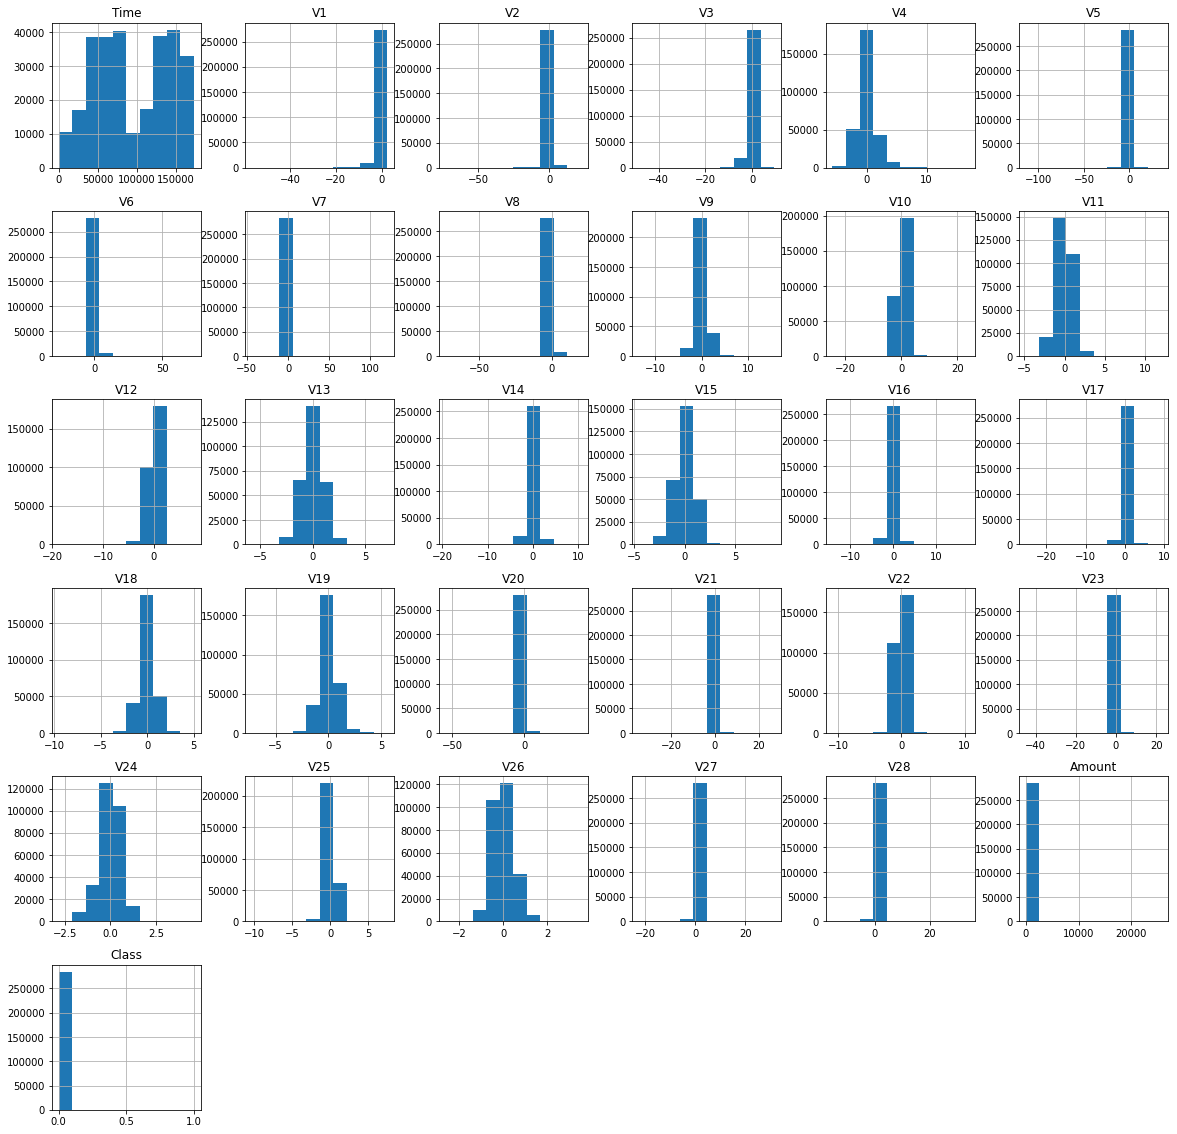

time: 4.49 s (started: 2022-05-10 00:30:53 +00:00)


In [ ]:
data.hist(figsize=(20, 20))
plt.show()

### Correlations

In [ ]:
data.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


time: 883 ms (started: 2022-05-10 00:30:57 +00:00)


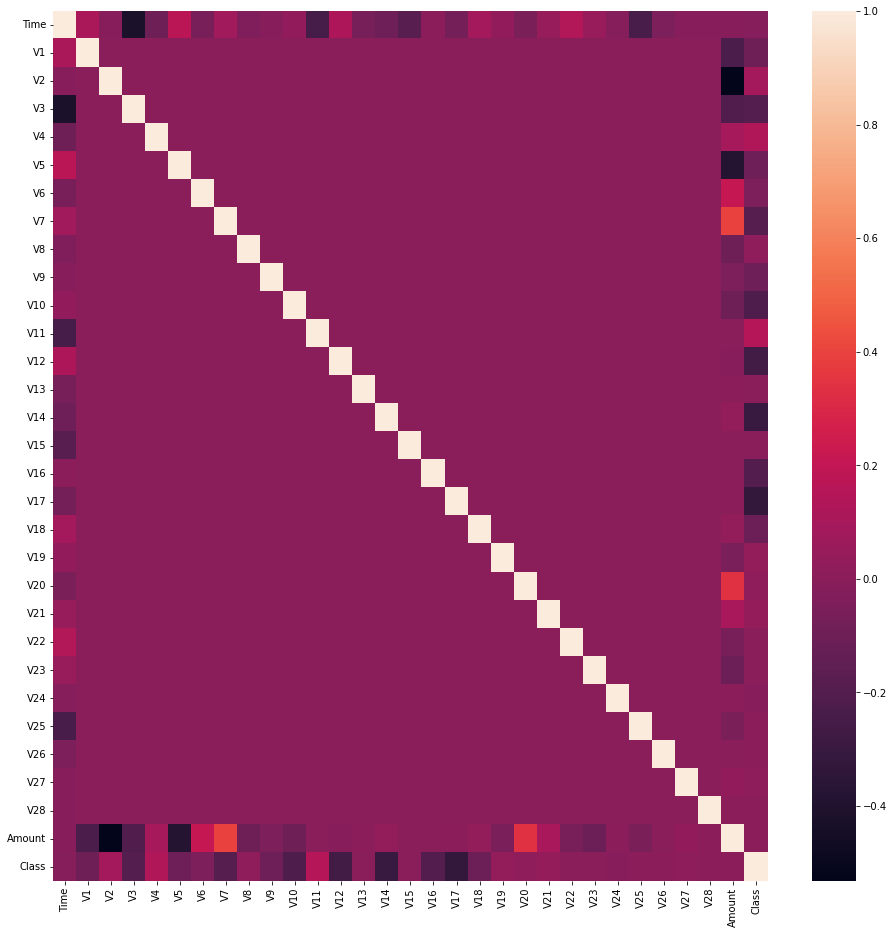

time: 1.57 s (started: 2022-05-10 00:30:58 +00:00)


In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(data.corr())

Correlations with the target variable

In [ ]:
abs(data.corr()['Class']).sort_values(ascending=False)

Class     1.000000
V17       0.326481
V14       0.302544
V12       0.260593
V10       0.216883
V16       0.196539
V3        0.192961
V7        0.187257
V11       0.154876
V4        0.133447
V18       0.111485
V1        0.101347
V9        0.097733
V5        0.094974
V2        0.091289
V6        0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time      0.012323
V28       0.009536
V24       0.007221
Amount    0.005632
V13       0.004570
V26       0.004455
V15       0.004223
V25       0.003308
V23       0.002685
V22       0.000805
Name: Class, dtype: float64

time: 817 ms (started: 2022-05-10 00:30:59 +00:00)


Correlations with amount

In [ ]:
abs(data.corr()['Amount']).sort_values(ascending=False)

Amount    1.000000
V2        0.531409
V7        0.397311
V5        0.386356
V20       0.339403
V1        0.227709
V6        0.215981
V3        0.210880
V23       0.112633
V21       0.105999
V8        0.103079
V10       0.101502
V4        0.098732
V22       0.064801
V19       0.056151
V25       0.047837
V9        0.044246
V18       0.035650
V14       0.033751
V27       0.028825
Time      0.010596
V28       0.010258
V12       0.009542
V17       0.007309
Class     0.005632
V13       0.005293
V24       0.005146
V16       0.003910
V26       0.003208
V15       0.002986
V11       0.000104
Name: Amount, dtype: float64

time: 826 ms (started: 2022-05-10 00:31:00 +00:00)


## Preprocessing

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. So, we don't need it.

In [ ]:
data = data.drop(['Time'], axis = 1)

time: 18.5 ms (started: 2022-05-10 00:31:01 +00:00)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

### Split dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:,data.columns != "Class"], 
    data.loc[:,"Class"], 
    test_size=0.20, 
    random_state=42, 
    stratify=data.loc[:,"Class"]
)

time: 196 ms (started: 2022-05-10 00:31:01 +00:00)


Lets see the split. Just in case.

In [ ]:
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

time: 8.48 ms (started: 2022-05-10 00:31:01 +00:00)


In [ ]:
y_test.value_counts()

0    56864
1       98
Name: Class, dtype: int64

time: 7.89 ms (started: 2022-05-10 00:31:01 +00:00)


# Model Selection

## KNN

### Models

Running GridSearchCV on a sample of 10% we found the best k=7, leaf_size=15, and weights='distance'

We will train KNN using a 20% sample of the training data since the computation is expensive. Also, we use MinMaxScaler to scale the training data.

In [ ]:
knn_X_train_sample, knn_y_train_sample = resample(
    X_train, 
    y_train, 
    n_samples=X_train.shape[0] * 0.2, 
    replace=True, 
    stratify=y_train, 
    random_state=0
)

time: 114 ms (started: 2022-05-09 13:55:24 +00:00)


#### Base Model

In [ ]:
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

knn = Pipeline([
                ('mms', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance'))])

scores = cross_validate(knn, knn_X_train_sample, knn_y_train_sample, scoring=scoring, cv=StratifiedKFold(5), n_jobs=-1)

print("Base Model scores for 'KNN  Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

Base Model scores for 'KNN  Classifier:'
fit_time: 0.037488555908203124
score_time: 17.4832444190979
test_accuracy: 0.9995391584668261
test_precision: 0.9161904761904761
test_recall: 0.8099999999999999
test_f1: 0.8592361883574341
test_roc_auc: 0.9177575199677583
time: 51.4 s (started: 2022-05-09 13:55:24 +00:00)


#### Oversampling

In [ ]:
model = make_pipeline(
    MinMaxScaler(),
    RandomOverSampler(random_state=0),
    KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance')
)

cv_results = cross_validate(
    model,
    knn_X_train_sample,
    knn_y_train_sample, 
    scoring=scoring,
    n_jobs=-1,
    cv=StratifiedKFold(5)
)


print("Base Model scores for KNN With Oversampling Classifier:'")
for m in cv_results:
    print(f'{m}: {cv_results[m].mean()}')

Base Model scores for KNN With Oversampling Classifier:'
fit_time: 0.05136394500732422
score_time: 29.62744951248169
test_accuracy: 0.999144159350448
test_precision: 0.7222832817337461
test_recall: 0.8358333333333334
test_f1: 0.7735714285714286
test_roc_auc: 0.9177111269876164
time: 1min 24s (started: 2022-05-09 13:56:15 +00:00)


#### Undersampling

In [ ]:
model = make_pipeline(
    MinMaxScaler(),
    RandomUnderSampler(random_state=0),
    KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance')
)

cv_results = cross_validate(
    model,
    knn_X_train_sample,
    knn_y_train_sample,  
    scoring=scoring,
    n_jobs=-1,
    cv=StratifiedKFold(5)
)

print("Base Model scores for KNN With Undersampling Classifier:'")
for m in cv_results:
    print(f'{m}: {cv_results[m].mean()}')

Base Model scores for KNN With Undersampling Classifier:'
fit_time: 0.040561580657958986
score_time: 0.12767367362976073
test_accuracy: 0.9831906161685213
test_precision: 0.12042680258383917
test_recall: 0.8858333333333335
test_f1: 0.2007139996536415
test_roc_auc: 0.9512038360079138
time: 654 ms (started: 2022-05-09 13:57:40 +00:00)


#### Bagging

In [ ]:
clf = BaggingClassifier(
    base_estimator= KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance'),
    bootstrap=False, 
    random_state=0, 
    max_samples=0.2, 
    n_estimators=10
)

model = make_pipeline(
    MinMaxScaler(),
    clf
)

cv_results = cross_validate(
    model,
    knn_X_train_sample,
    knn_y_train_sample, 
    scoring=scoring,
    cv=KFold(5)
)

print("Base Model scores for KNN With Bagging Classifier:'")
for m in cv_results:
    print(f'{m}: {cv_results[m].mean()}')

Base Model scores for KNN With Bagging Classifier:'
fit_time: 0.06049776077270508
score_time: 25.86867752075195
test_accuracy: 0.999122212680855
test_precision: 0.9095238095238095
test_recall: 0.5466666666666666
test_f1: 0.6819272445820432
test_roc_auc: 0.9267335665747096
time: 2min 9s (started: 2022-05-09 13:57:41 +00:00)


### Choice

**Best KNN Model is the base line with:**
test_f1: 0.86

**Other results**


*Undersampling*
test_f1: 0.20

*Oversampling*
test_f1: 0.77

*Bagging*
test_f1: 0.69

### Feature Selection

In the cells below we use RFECV and SFS to find the best features. They were commented out to speed up the notebook execution.

#### Recursive Feature Elimination using CV

In [ ]:
'''

# Create the RFE object and compute a cross-validated score.
clf = RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)


rfecv = RFECV(
    estimator=clf,
    step=4,
    cv=StratifiedKFold(5),
    scoring="f1",
    n_jobs=-1
)

rfecv.fit(knn_X_train_sample, knn_y_train_sample)

print("Optimal number of features : %d" % rfecv.n_features_)

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

knn = Pipeline([('mms', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance'))])

scores = cross_validate(
    knn, 
    knn_X_train_sample.iloc[:, rfecv.support_], 
    knn_y_train_sample, 
    scoring=scoring, 
    cv=StratifiedKFold(5), 
    n_jobs=-1
    )

print("Model scores for 'KNN Best Classifier using features from RFECV:'")

for m in scores:
    print(f'{m}: {scores[m].mean()}')

'''

'\n\n# Create the RFE object and compute a cross-validated score.\nclf = RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)\n\n\nrfecv = RFECV(\n    estimator=clf,\n    step=4,\n    cv=StratifiedKFold(5),\n    scoring="f1",\n    n_jobs=-1\n)\n\nrfecv.fit(knn_X_train_sample, knn_y_train_sample)\n\nprint("Optimal number of features : %d" % rfecv.n_features_)\n\nscoring = [\'accuracy\', \'balanced_accuracy\', \'precision\', \'recall\', \'f1\']\n\nknn = Pipeline([(\'mms\', MinMaxScaler()),\n                (\'knn\', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights=\'distance\'))])\n\nscores = cross_validate(\n    knn, \n    knn_X_train_sample.iloc[:, rfecv.support_], \n    knn_y_train_sample, \n    scoring=scoring, \n    cv=StratifiedKFold(5), \n    n_jobs=-1\n    )\n\nprint("Model scores for \'KNN Best Classifier using features from RFECV:\'")\n\nfor m in scores:\n    print(f\'{m}: {scores[m].mean()}\')\n\n'

time: 9.09 ms (started: 2022-05-09 13:59:50 +00:00)


Optimal number of features : 9

fit_time: 0.12910280227661133

score_time: 1.6074413299560546

test_accuracy: 0.9995172142052503

test_balanced_accuracy: 0.9049230600131898

test_precision: 0.9038095238095238

test_recall: 0.8099999999999999

test_f1: 0.8536447905079718

time: 4min 6s (started: 2022-05-08 05:57:13 +00:00)

#### Sequential Foward Search

In [ ]:
'''

knn = Pipeline([('mms', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance'))])

sfs_forward = SequentialFeatureSelector(
    knn,
    direction="forward",
    scoring='f1',
    cv=KFold(5),
    n_features_to_select=3,
    n_jobs=-1
).fit(X_train, y_train)


scores = cross_validate(
    knn,
    knn_X_train_sample.iloc[:, sfs_forward.get_support()], 
    knn_y_train_sample,  
    scoring=scoring, 
    cv=StratifiedKFold(5)
)

print("Model scores for 'KNN Best Classifier using features from Sequential Feature Selection:'")
for m in scores:
    print(f'{m}: {scores[m].mean()}')

'''

'\n\nknn = Pipeline([(\'mms\', MinMaxScaler()),\n                (\'knn\', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights=\'distance\'))])\n\nsfs_forward = SequentialFeatureSelector(\n    knn,\n    direction="forward",\n    scoring=\'f1\',\n    cv=KFold(5),\n    n_features_to_select=3,\n    n_jobs=-1\n).fit(X_train, y_train)\n\n\nscores = cross_validate(\n    knn,\n    knn_X_train_sample.iloc[:, sfs_forward.get_support()], \n    knn_y_train_sample,  \n    scoring=scoring, \n    cv=StratifiedKFold(5)\n)\n\nprint("Model scores for \'KNN Best Classifier using features from Sequential Feature Selection:\'")\nfor m in scores:\n    print(f\'{m}: {scores[m].mean()}\')\n\n'

time: 8.02 ms (started: 2022-05-09 13:59:50 +00:00)


Model scores for 'KNN Best Classifier using features from Sequential Feature Selection:'

fit_time: 0.03556909561157227

score_time: 0.06577653884887695

test_accuracy: 0.9994733256820993

test_balanced_accuracy: 0.8924230600131897

test_precision: 0.8989010989010989

test_recall: 0.7849999999999999

test_f1: 0.8377011494252873

time: 2min 56s (started: 2022-05-08 06:46:25 +00:00)

### Decision

The base model without feature selection has better performance.

## Naive Bayes

Metrics for comparison.

In [ ]:
scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

time: 1.18 ms (started: 2022-05-09 13:59:50 +00:00)


### Models

#### Baseline Model

In [ ]:
gnb = GaussianNB()
scores = cross_validate(gnb, X_train, y_train, scoring=scoring, cv=StratifiedKFold(5))

print("Base Model scores for 'Naive Bayes Classifier:'")

for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

Base Model scores for 'Naive Bayes Classifier:'
fit_time: 0.10467195510864258
score_time: 0.07838625907897949
test_accuracy: 0.9779938115824354
test_balanced_accuracy: 0.9014469551412578
test_precision: 0.061675833240426525
test_recall: 0.8246348588120739
test_f1: 0.11476400232455333
time: 963 ms (started: 2022-05-09 13:59:50 +00:00)


#### With Oversampling

In [ ]:
model = make_pipeline(
    RandomOverSampler(random_state=0),
    GaussianNB()
)

cv_results = cross_validate(
    model,
    X_train,
    y_train, 
    scoring=scoring,
    n_jobs=-1,
    cv=StratifiedKFold(5)
)

print("Model scores for 'Naive Bayes with Oversampling Classifier:'")

for m in cv_results:
    print(f'{m}: {cv_results[m].mean()}')

Model scores for 'Naive Bayes with Oversampling Classifier:'
fit_time: 0.6792220115661621
score_time: 0.11331400871276856
test_accuracy: 0.9741754262766353
test_balanced_accuracy: 0.9135154669964448
test_precision: 0.054545484704371726
test_recall: 0.8526452450503083
test_f1: 0.10252809914815239
time: 2.48 s (started: 2022-05-09 13:59:51 +00:00)


#### With Undersampling

In [ ]:
model = make_pipeline(
    RandomUnderSampler(random_state=0),
    GaussianNB()
)

cv_results = cross_validate(
    model,
    X_train,
    y_train, 
    scoring=scoring,
    n_jobs=-1
)


print("Model scores for 'Naive Bayes with Undersampling Classifier:'")
for m in cv_results:
    print(f'{m}: {cv_results[m].mean()}')

Model scores for 'Naive Bayes with Undersampling Classifier:'
fit_time: 0.12498741149902344
score_time: 0.12177391052246093
test_accuracy: 0.9658144791415216
test_balanced_accuracy: 0.9144147245669952
test_precision: 0.0431246176451684
test_recall: 0.8628367413177539
test_f1: 0.08205187997707826
time: 916 ms (started: 2022-05-09 13:59:54 +00:00)


#### With Bagging

In [ ]:
clf = BaggingClassifier(
    base_estimator=GaussianNB(),
    bootstrap=False, 
    random_state=0, 
    n_jobs=-1, 
    max_samples=0.1, 
    n_estimators=100
)

scores = cross_validate(
    clf, 
    X_train, 
    y_train, 
    scoring=scoring, 
    cv=StratifiedKFold(5), 
    n_jobs=-1
)


print("Model scores for 'Naive Bayes with Bagging Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')


Model scores for 'Naive Bayes with Bagging Classifier:'
fit_time: 17.66060152053833
score_time: 4.281073951721192
test_accuracy: 0.979723057341614
test_balanced_accuracy: 0.9023130748285026
test_precision: 0.06665449553504779
test_recall: 0.8246348588120739
test_f1: 0.12332948644905233
time: 1min (started: 2022-05-09 13:59:55 +00:00)


### Choice

**Best Naive Bayes is the base line with:**
test_f1: 0.11

**Other results**


*Undersampling*
test_f1: 0.08

*Oversampling*
test_f1: 0.10

*Bagging*
test_f1: 0.12

### Feature *Selection*

Bagging has the best F1 but is a 1% difference. So the basic naive Bayes is preferred because it's faster.

#### Recursive Feature Elimination using CV

This function is computationally expensive. Let's create a 1/3 sample of the training dataset to make things faster.

In [ ]:
from sklearn.utils import resample

X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.1, replace=True, stratify=y_train, random_state=0)

time: 35.6 ms (started: 2022-05-09 14:00:56 +00:00)


In [ ]:
'''

# Create the RFE object and compute a cross-validated score.
clf = RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)


rfecv = RFECV(
    estimator=clf,
    step=2,
    cv=KFold(5),
    scoring="f1",
    n_jobs=-1
)

rfecv.fit(X_train_sample, y_train_sample)

print("Optimal number of features : %d" % rfecv.n_features_)

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores = cross_validate(
    GaussianNB(), 
    X_train.iloc[:, rfecv.support_], 
    y_train, 
    scoring=scoring, 
    cv=StratifiedKFold(5), 
    n_jobs=-1
    )

print("Model scores for 'Naive Bayes Best Classifier using features from RFECV:'")

for m in scores:
    print(f'{m}: {scores[m].mean()}')


'''

'\n\n# Create the RFE object and compute a cross-validated score.\nclf = RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)\n\n\nrfecv = RFECV(\n    estimator=clf,\n    step=2,\n    cv=KFold(5),\n    scoring="f1",\n    n_jobs=-1\n)\n\nrfecv.fit(X_train_sample, y_train_sample)\n\nprint("Optimal number of features : %d" % rfecv.n_features_)\n\nscoring = [\'accuracy\', \'balanced_accuracy\', \'precision\', \'recall\', \'f1\']\n\nscores = cross_validate(\n    GaussianNB(), \n    X_train.iloc[:, rfecv.support_], \n    y_train, \n    scoring=scoring, \n    cv=StratifiedKFold(5), \n    n_jobs=-1\n    )\n\nprint("Model scores for \'Naive Bayes Best Classifier using features from RFECV:\'")\n\nfor m in scores:\n    print(f\'{m}: {scores[m].mean()}\')\n\n\n'

time: 6.93 ms (started: 2022-05-09 14:00:56 +00:00)


Optimal number of features : 5

Model scores for 'Naive Bayes Best Classifier using features from RFECV:'

fit_time: 0.07235217094421387

score_time: 0.09405994415283203

test_accuracy: 0.9909324321358819

test_balanced_accuracy: 0.9155903609499207

test_precision: 0.1418677302290157

test_recall: 0.8399870172022071

test_f1: 0.2427027351913081

time: 2min 16s (started: 2022-05-08 17:40:43 +00:00)

#### Sequential Foward Search

In [ ]:
'''
gnb = GaussianNB()

sfs_forward = SequentialFeatureSelector(
    gnb,
    direction="forward",
    scoring='f1',
    cv=KFold(5),
    n_jobs=-1
).fit(X_train, y_train)


scores = cross_validate(
    gnb,
    X_train.iloc[:,sfs_forward.get_support()], 
    y_train, 
    scoring=scoring, 
    cv=5
)

print("Model scores for 'Naive Bayes Best Classifier using features from SFS:'")

for m in scores:
    print(f'{m}: {scores[m].mean()}')

'''

'\ngnb = GaussianNB()\n\nsfs_forward = SequentialFeatureSelector(\n    gnb,\n    direction="forward",\n    scoring=\'f1\',\n    cv=KFold(5),\n    n_jobs=-1\n).fit(X_train, y_train)\n\n\nscores = cross_validate(\n    gnb,\n    X_train.iloc[:,sfs_forward.get_support()], \n    y_train, \n    scoring=scoring, \n    cv=5\n)\n\nprint("Model scores for \'Naive Bayes Best Classifier using features from SFS:\'")\n\nfor m in scores:\n    print(f\'{m}: {scores[m].mean()}\')\n\n'

time: 4.98 ms (started: 2022-05-09 14:00:56 +00:00)


Model scores for 'Naive Bayes Best Classifier using features from SFS:'

fit_time: 0.06439933776855469

score_time: 0.06754279136657715

test_accuracy: 0.9960718909785161

test_balanced_accuracy: 0.9131100443060232

test_precision: 0.28402825954719707

test_recall: 0.8298604349237261

test_f1: 0.4228157105320086

time: 2min 39s (started: 2022-05-08 17:44:28 +00:00)

### Decision

The best model is Base Naive Bayes with Sequential Forward.

test_f1: 0.42

## Decision Tree

### Models

In [ ]:
# Creating list with scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

time: 1.36 ms (started: 2022-05-09 14:00:56 +00:00)


#### *Base Models*

In [ ]:
# Setting Decision tree parameters 
model = DecisionTreeClassifier(criterion="entropy", random_state=0)

# Training model
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)

# Output Results
print("Base Model scores for 'Decision Tree Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

Base Model scores for 'Decision Tree Classifier:'
fit_time: 13.262457752227784
score_time: 0.0934783935546875
test_accuracy: 0.9992231560929581
test_precision: 0.7886484405540667
test_recall: 0.7561506004543979
test_f1: 0.7707309059133435
test_roc_auc: 0.8778972397430722
time: 38 s (started: 2022-05-09 14:00:56 +00:00)


#### Undersampling

In [ ]:
# Getting total count to compare
print("Original Data count: ", Counter(y_train))

# Setup undersample
undersampling = RandomUnderSampler(sampling_strategy='majority')

# Pass X & Y train for undersample
X_train_under, y_train_under = undersampling.fit_resample(X_train, y_train)

# Count After undersample
print("Undersample Count: ", Counter(y_train_under))

# Using pipeline to pass undersample & decision Tree and generate score on Cross Validation
model = make_pipeline(
    RandomUnderSampler(),
    DecisionTreeClassifier(criterion="entropy")
) 

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)

# Output Results
print("Undersampling Model scores for 'Decision Tree Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

Original Data count:  Counter({0: 227451, 1: 394})
Undersample Count:  Counter({0: 394, 1: 394})
Undersampling Model scores for 'Decision Tree Classifier:'
fit_time: 0.13398656845092774
score_time: 0.112408447265625
test_accuracy: 0.9117206873093551
test_precision: 0.017426499900072636
test_recall: 0.8983122362869199
test_f1: 0.0341856196649924
test_roc_auc: 0.9050279114712565
time: 1.02 s (started: 2022-05-09 14:01:34 +00:00)


####Oversampling

In [ ]:
# Getting total count to compare
print("Original Data count: ", Counter(y_train))

# Setup Oversampler
oversampling = RandomOverSampler(sampling_strategy='minority')

X_train_over, y_train_over = oversampling.fit_resample(X_train, y_train)

# Count After undersample
print("Oversample Count: ", Counter(y_train_over))

# Using pipeline to pass undersample & decision Tree and generate score on Cross Validation
model = make_pipeline(RandomOverSampler(),
                      DecisionTreeClassifier(criterion="entropy")
                    ) 

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(model, 
                        X_train, 
                        y_train, 
                        scoring=scoring, 
                        cv=5, 
                        n_jobs=-1)

# Output Results
print("Oversampling Model scores for 'Decision Tree Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

Original Data count:  Counter({0: 227451, 1: 394})
Oversample Count:  Counter({0: 227451, 1: 227451})
Oversampling Model scores for 'Decision Tree Classifier:'
fit_time: 12.76685609817505
score_time: 0.12033801078796387
test_accuracy: 0.9991529329149202
test_precision: 0.779582650703076
test_recall: 0.7157091853294386
test_f1: 0.7452016760565556
test_roc_auc: 0.8576765324222103
time: 37.7 s (started: 2022-05-09 14:01:35 +00:00)


####SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Using pipeline to pass oversample, undersample & decision Tree and generate score on Cross Validation
model = make_pipeline(
    SMOTE(sampling_strategy=0.1), 
    DecisionTreeClassifier(criterion="entropy")) 

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(model, 
                        X_train, 
                        y_train, 
                        scoring=scoring, 
                        cv=5, 
                        n_jobs=-1)

# Output Results
print("SMOTE Model scores for 'Decision Tree Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

SMOTE Model scores for 'Decision Tree Classifier:'
fit_time: 15.709970474243164
score_time: 0.10147013664245605
test_accuracy: 0.998103974192982
test_precision: 0.47687723178289215
test_recall: 0.8044466082440765
test_f1: 0.5967299241282878
test_roc_auc: 0.9014429151951008
time: 44.2 s (started: 2022-05-09 14:02:13 +00:00)


**Best Decision Tree Model is the base line with:**
test_f1: 0.8160541384855333

**Other target the following results**

*Base Model scores for 'Decision Tree Classifier:'*
test_recall: 0.7942948717948718 & test_f1: 0.8160541384855333

*Undersampling Model scores for 'Decision Tree Classifier:'*
test_recall: 0.8802564102564101 & test_f1: 0.07949783603414408

*Oversampling Model scores for 'Decision Tree Classifier:'*
test_recall: 0.8830128205128205 & test_f1: 0.08943459980458608

*SMOTE Model scores for 'Decision Tree Classifier:'*
test_recall: 0.8804487179487179 & test_f1: 0.12004138306640919

###Feature Selection 

####Recursive Feature

Sample 30% of data for faster feature selection.

In [ ]:
from sklearn.utils import resample
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.3, replace=True, stratify=y_train, random_state=0)

time: 53.7 ms (started: 2022-05-09 14:02:57 +00:00)


In [ ]:
'''
# Setting Decision tree parameters 
model = DecisionTreeClassifier(criterion="entropy")

# Setting Recursive_Feature parameters 
Recursive_Feature = RFECV(
    estimator=model,
    step=2,
    cv=KFold(5),
    scoring="f1")

Recursive_Feature.fit(X_train_sample, y_train_sample)

# Training model
scores = cross_validate(
    model,
    X_train_sample.iloc[:,Recursive_Feature.support_], 
    y_train_sample, 
    scoring=scoring, 
    cv=5, 
    n_jobs=-1)

# Output Results
print(f"Recursive scores for 'Decision Tree Classifier with {Recursive_Feature.n_features_} Features:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

'''

'\n# Setting Decision tree parameters \nmodel = DecisionTreeClassifier(criterion="entropy")\n\n# Setting Recursive_Feature parameters \nRecursive_Feature = RFECV(\n    estimator=model,\n    step=2,\n    cv=KFold(5),\n    scoring="f1")\n\nRecursive_Feature.fit(X_train_sample, y_train_sample)\n\n# Training model\nscores = cross_validate(\n    model,\n    X_train_sample.iloc[:,Recursive_Feature.support_], \n    y_train_sample, \n    scoring=scoring, \n    cv=5, \n    n_jobs=-1)\n\n# Output Results\nprint(f"Recursive scores for \'Decision Tree Classifier with {Recursive_Feature.n_features_} Features:\'")\nfor m in scores:\n    print(f\'{m}: {np.mean(scores[m])}\')\n\n'

time: 6.77 ms (started: 2022-05-09 14:02:57 +00:00)


Recursive scores for 'Decision Tree Classifier with 25 Features:'

fit_time: 2.57745156288147

score_time: 0.0328577995300293

test_accuracy: 0.9992538769131867

test_precision: 0.7742643829600352

test_recall: 0.8134057971014494

test_f1: 0.7912629111671393

test_roc_auc: 0.9064903976347723

time: 1min 40s (started: 2022-05-08 18:00:27 +00:00)

####Forward selection

Sample 20% since this method is more expensive

In [ ]:
from sklearn.utils import resample
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.2, replace=True, stratify=y_train, random_state=0)

time: 42.5 ms (started: 2022-05-09 14:02:57 +00:00)


In [ ]:
'''
model = DecisionTreeClassifier(criterion="entropy")

Forward_Selection = SequentialFeatureSelector(
    estimator=model, 
    direction="forward",
    scoring='f1',
    n_features_to_select=5,
    cv=KFold(5))

Forward_Selection.fit(X_train_sample, y_train_sample)

# Training model
scores = cross_validate(model,
                        X_train_sample.iloc[:,Forward_Selection.support_], 
                        y_train_sample, 
                        scoring=scoring, 
                        cv=5, 
                        n_jobs=-1)

# Output Results
print(f"Forward Selection scores for 'Decision Tree Classifier with {Forward_Selection.n_features_to_select_} Features:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

'''

'\nmodel = DecisionTreeClassifier(criterion="entropy")\n\nForward_Selection = SequentialFeatureSelector(\n    estimator=model, \n    direction="forward",\n    scoring=\'f1\',\n    n_features_to_select=5,\n    cv=KFold(5))\n\nForward_Selection.fit(X_train_sample, y_train_sample)\n\n# Training model\nscores = cross_validate(model,\n                        X_train_sample.iloc[:,Forward_Selection.support_], \n                        y_train_sample, \n                        scoring=scoring, \n                        cv=5, \n                        n_jobs=-1)\n\n# Output Results\nprint(f"Forward Selection scores for \'Decision Tree Classifier with {Forward_Selection.n_features_to_select_} Features:\'")\nfor m in scores:\n    print(f\'{m}: {np.mean(scores[m])}\')\n\n'

time: 5.47 ms (started: 2022-05-09 14:02:57 +00:00)


Forward Selection scores for 'Decision Tree Classifier with 5 Features:'

fit_time: 0.33429946899414065

score_time: 0.026198291778564455

test_accuracy: 0.9992099921351747

test_precision: 0.769270876182641

test_recall: 0.7966666666666666

test_f1: 0.7778308491169271

test_roc_auc: 0.8981135047995895

time: 2min 1s (started: 2022-05-08 18:02:07 +00:00)

####Backward selection --> Commenting it out since takes really long time

Will need to take a sample of the date due to high computational performance if we use current training data




In [ ]:
from sklearn.utils import resample
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.1, replace=True, stratify=y_train, random_state=0)

time: 35.1 ms (started: 2022-05-09 14:02:57 +00:00)


In [ ]:
# model = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Forward_Selection = SequentialFeatureSelector(estimator=model, n_features_to_select=5, direction="backward")
# Forward_Selection.fit(X_train_sample, y_train_sample)

# # Training model
# scores = cross_validate(model, X_train.iloc[:,Forward_Selection.support_], y_train, scoring=scoring, cv=10, n_jobs=-1)

# # Output Results
# print("Backward Selection scores for 'Decision Tree Classifier with 5 Features:'")
# for m in scores:
#     print(f'{m}: {np.mean(scores[m])}')

time: 2.63 ms (started: 2022-05-09 14:02:57 +00:00)


**Best Feature selection for Decision Tree Model is the recursive:**
test_f1: 0.79

### Decision

We choose the Base Model without feature selection due to computational cost. There is an improvement of 2% using feature selection.

## Random Forest

Use a 20% sample to speed up training

In [ ]:
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.2, replace=True, stratify=y_train, random_state=0)

time: 42.8 ms (started: 2022-05-09 14:02:57 +00:00)


###Models

In [ ]:
# Creating list with scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

time: 3.61 ms (started: 2022-05-09 14:02:57 +00:00)


####Base Models

In [ ]:
clf = RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)

'''
rf = Pipeline([
                ('mms', MinMaxScaler()),
                ('rf', clf)])
'''

scores = cross_validate(clf, X_train_sample, y_train_sample, scoring=scoring, cv=5, n_jobs=-1)

print("Base Model scores for 'Random Forest  Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

Base Model scores for 'Random Forest  Classifier:'
fit_time: 9.670401668548584
score_time: 0.26738815307617186
test_accuracy: 0.9994513814205236
test_precision: 0.9263736263736263
test_recall: 0.7474999999999999
test_f1: 0.8237312113174182
test_roc_auc: 0.9356551806257786
time: 27.5 s (started: 2022-05-09 14:02:57 +00:00)


####Undersampling

In [ ]:

# Getting total count to compare
print("Original Data count: ", Counter(y_train))

# Setup undersample
undersampling = RandomUnderSampler(sampling_strategy='majority')

# Pass X & Y train for undersample
X_train_under, y_train_under = undersampling.fit_resample(X_train, y_train)

# Count After undersample
print("Undersample Count: ", Counter(y_train_under))

# Using pipeline to pass undersample & decision Tree and generate score on Cross Validation
model = make_pipeline(
    RandomUnderSampler(),
    RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)
) 

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)


# Output Results
print("Undersampling Model scores for 'Random Forest Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

Original Data count:  Counter({0: 227451, 1: 394})
Undersample Count:  Counter({0: 394, 1: 394})
Undersampling Model scores for 'Random Forest Classifier:'
fit_time: 0.4032750606536865
score_time: 0.6369720458984375
test_accuracy: 0.974750378546819
test_precision: 0.058591077538720726
test_recall: 0.8984096072703668
test_f1: 0.10997084719388173
test_roc_auc: 0.9808039149938363
time: 3.27 s (started: 2022-05-09 14:03:25 +00:00)


####Oversampling

In [ ]:
# Getting total count to compare
print("Original Data count: ", Counter(y_train_sample))

# Setup undersample
oversampling = RandomOverSampler(sampling_strategy='minority')

# Pass X & Y train for undersample

X_train_over, y_train_over = oversampling.fit_resample(X_train_sample, y_train_sample)
#X_train_over, y_train_over = oversampling.fit_resample(X_train, y_train)

# Count After undersample
print("Oversample Count: ", Counter(y_train_over))

# Using pipeline to pass undersample & decision Tree and generate score on Cross Validation
model = make_pipeline(
    RandomOverSampler(random_state=0),
    RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)
) 

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(model, X_train_sample, y_train_sample, scoring=scoring, cv=5, n_jobs=-1)


# Output Results
print("Oversampling Model scores for 'Random Forest Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')


Original Data count:  Counter({0: 45490, 1: 79})
Oversample Count:  Counter({0: 45490, 1: 45490})
Oversampling Model scores for 'Random Forest Classifier:'
fit_time: 10.892244815826416
score_time: 0.23058576583862306
test_accuracy: 0.9994513814205236
test_precision: 0.9119047619047619
test_recall: 0.76
test_f1: 0.8274220032840722
test_roc_auc: 0.941561698541804
time: 31.3 s (started: 2022-05-09 14:03:28 +00:00)


####SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Using pipeline to pass oversample, undersample & decision Tree and generate score on Cross Validation
model = make_pipeline(
    SMOTE(random_state=0), 
    RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)
) 

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(model, X_train_sample, y_train_sample, scoring=scoring, cv=5, n_jobs=-1)

# Output Results
print("SMOTE Model scores for 'Random Forest Classifier:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

SMOTE Model scores for 'Random Forest Classifier:'
fit_time: 25.501894903182983
score_time: 0.2550495624542236
test_accuracy: 0.9994952699436748
test_precision: 0.8808963585434173
test_recall: 0.8225
test_f1: 0.8496228132268178
test_roc_auc: 0.9522466018172493
time: 1min 11s (started: 2022-05-09 14:03:59 +00:00)


### Decision

SMOTE has a better F1 by a small margin. Since this difference is about 3%, we stick with the base model.

**Best Random Forest Model is the SMOTE with:**
test_f1: 0.85

**Other target the following results**

*Base Model scores for 'Random Forest Classifier:'*
test_f1: 0.82

*Undersampling Model scores for 'Random Forest Classifier:'*
test_f1: 0.13

*Oversampling Model scores for 'Random Forest Classifier:'*
test_f1: 0.83


###Feature Selection

####Recursive Feature

In [ ]:
from sklearn.utils import resample
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.1, replace=True, stratify=y_train, random_state=0)

time: 39.3 ms (started: 2022-05-09 14:05:10 +00:00)


In [ ]:
'''

# Setting Decision tree parameters 
model = RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)

# Setting Recursive_Feature parameters 
Recursive_Feature = RFECV(
    estimator=model,
    step=4,
    cv=KFold(5),
    scoring="f1",
    n_jobs=-1
)
Recursive_Feature.fit(X_train_sample, y_train_sample)

# Training model
scores = cross_validate(model, 
                        X_train_sample.iloc[:,Recursive_Feature.support_], 
                        y_train_sample, 
                        scoring=scoring, 
                        cv=5, 
                        n_jobs=-1)

# Output Results
print("Recursive scores for 'Random Forest Classifier with 5 Features:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

'''

'\n\n# Setting Decision tree parameters \nmodel = RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)\n\n# Setting Recursive_Feature parameters \nRecursive_Feature = RFECV(\n    estimator=model,\n    step=4,\n    cv=KFold(5),\n    scoring="f1",\n    n_jobs=-1\n)\nRecursive_Feature.fit(X_train_sample, y_train_sample)\n\n# Training model\nscores = cross_validate(model, \n                        X_train_sample.iloc[:,Recursive_Feature.support_], \n                        y_train_sample, \n                        scoring=scoring, \n                        cv=5, \n                        n_jobs=-1)\n\n# Output Results\nprint("Recursive scores for \'Random Forest Classifier with 5 Features:\'")\nfor m in scores:\n    print(f\'{m}: {np.mean(scores[m])}\')\n\n'

time: 8.06 ms (started: 2022-05-09 14:05:10 +00:00)


*italicized text*####Forward Selection


Takes too much time, this method will be omitted.

In [ ]:
from sklearn.utils import resample
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.1, replace=True, stratify=y_train, random_state=0)

time: 34.1 ms (started: 2022-05-09 14:05:10 +00:00)


In [ ]:
'''

model = RandomForestClassifier(
    criterion="entropy", 
    random_state=0, 
    n_jobs=-1, 
    n_estimators=50
)

# Setting SequentialFeatureSelector parameters 
Forward_Selection = SequentialFeatureSelector(
    estimator=model, 
    direction="forward",
    scoring='f1',
    n_features_to_select=5,
    cv=KFold(5))
Forward_Selection.fit(X_train_sample, y_train_sample)


# Training model
scores = cross_validate(model, 
                        X_train_sample.iloc[:,Forward_Selection.support_], 
                        y_train_sample, 
                        scoring=scoring, 
                        cv=5, 
                        n_jobs=-1)

# Output Results
print(f"Forward Selection scores for 'Random Forest Classifier with {n_features} Features:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

'''

'\n\nmodel = RandomForestClassifier(\n    criterion="entropy", \n    random_state=0, \n    n_jobs=-1, \n    n_estimators=50\n)\n\n# Setting SequentialFeatureSelector parameters \nForward_Selection = SequentialFeatureSelector(\n    estimator=model, \n    direction="forward",\n    scoring=\'f1\',\n    n_features_to_select=5,\n    cv=KFold(5))\nForward_Selection.fit(X_train_sample, y_train_sample)\n\n\n# Training model\nscores = cross_validate(model, \n                        X_train_sample.iloc[:,Forward_Selection.support_], \n                        y_train_sample, \n                        scoring=scoring, \n                        cv=5, \n                        n_jobs=-1)\n\n# Output Results\nprint(f"Forward Selection scores for \'Random Forest Classifier with {n_features} Features:\'")\nfor m in scores:\n    print(f\'{m}: {np.mean(scores[m])}\')\n\n'

time: 5.88 ms (started: 2022-05-09 14:05:10 +00:00)


####Backward Selection

Will need to take a sample of the date due to high computational performance if we use current training data

In [ ]:
from sklearn.utils import resample
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.1, replace=True, stratify=y_train, random_state=0)

time: 40.5 ms (started: 2022-05-09 14:05:10 +00:00)


In [ ]:
'''
model = RandomForestClassifier(criterion="entropy", max_depth=3)

Forward_Selection = SequentialFeatureSelector(estimator=model, n_features_to_select=5, direction="backward")
Forward_Selection.fit(X_train_sample, y_train_sample)

# Training model
scores = cross_validate(model, X_train.iloc[:,Forward_Selection.support_], y_train, scoring=scoring, cv=10, n_jobs=-1)

# Output Results
print("Forward Selection scores for 'Random Foreste Classifier with 5 Features:'")
for m in scores:
    print(f'{m}: {np.mean(scores[m])}')

'''

'\nmodel = RandomForestClassifier(criterion="entropy", max_depth=3)\n\nForward_Selection = SequentialFeatureSelector(estimator=model, n_features_to_select=5, direction="backward")\nForward_Selection.fit(X_train_sample, y_train_sample)\n\n# Training model\nscores = cross_validate(model, X_train.iloc[:,Forward_Selection.support_], y_train, scoring=scoring, cv=10, n_jobs=-1)\n\n# Output Results\nprint("Forward Selection scores for \'Random Foreste Classifier with 5 Features:\'")\nfor m in scores:\n    print(f\'{m}: {np.mean(scores[m])}\')\n\n'

time: 4.39 ms (started: 2022-05-09 14:05:10 +00:00)


## Ensemble Learner

### Voting Classifier

In [ ]:
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=X_train.shape[0] * 0.3, replace=True, stratify=y_train, random_state=0)

time: 52.7 ms (started: 2022-05-09 14:05:10 +00:00)


Source: 1.11.6 [Voting Classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

In [ ]:
# TO DO: Use the best parameters for each model
clf1 = Pipeline([('mms', MinMaxScaler()), ('knn', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance'))])
clf2 = GaussianNB()
clf3 = DecisionTreeClassifier(criterion="entropy", random_state=0)

eclf = VotingClassifier(
    estimators=[('knn', clf1), ('gnb', clf2),  ('dt', clf3)], 
    voting='hard'
)

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores = cross_validate(eclf, X_train_sample, y_train_sample, scoring=scoring, cv=KFold(5), n_jobs=-1)

for m in scores:
    print(f'{m}: {scores[m].mean()}')

fit_time: 3.0274776458740233
score_time: 19.65816903114319
test_accuracy: 0.9995757303637252
test_balanced_accuracy: 0.9259749233823721
test_precision: 0.900018315018315
test_recall: 0.852111046847889
test_f1: 0.8730922735800786
time: 1min 3s (started: 2022-05-09 14:05:11 +00:00)


# Evaluation

In this part, we'll train the best models found in model selection and then validate with the test data.

## KNN

Best KNN pipeline for training and predictions:

The base model without feature selection has better performance.

In [ ]:
knn_X_train_sample, knn_y_train_sample = resample(
    X_train, 
    y_train, 
    n_samples=X_train.shape[0] * 0.3, 
    replace=True, 
    stratify=y_train, 
    random_state=0
)

knn_pipe = Pipeline([
                ('mms', MinMaxScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance'))])

# Fit pipeline
knn_pipe.fit(knn_X_train_sample, knn_y_train_sample)

# Get preditions
knn_preds = knn_pipe.predict(X_test)

time: 1min 17s (started: 2022-05-10 00:31:29 +00:00)


## Naive Bayes

Naive bayes pipeline for training and predictions

In [ ]:
sfs_forward = SequentialFeatureSelector(
    GaussianNB(),
    direction="forward",
    scoring='f1',
    cv=5
)

naive_bayes_pipe = Pipeline([
('feature_selector', sfs_forward),
('classifier', GaussianNB())
])

# Fit pipeline
naive_bayes_pipe.fit(X_train, y_train)

# Get preditions
naive_preds = naive_bayes_pipe.predict(X_test)

time: 2min 45s (started: 2022-05-10 00:32:46 +00:00)


##Decision Tree

In [ ]:
#Feature_Selection = RFECV(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=3), min_features_to_select=5)

dt_pipe = Pipeline(
    [
     #('feature_selector', Feature_Selection),
     ('classifier', DecisionTreeClassifier(criterion="entropy", random_state=0))
     ])

# Fit pipeline
dt_pipe.fit(X_train, y_train)

# Get preditions
dt_pipe_preds = dt_pipe.predict(X_test)

time: 13.4 s (started: 2022-05-10 00:35:32 +00:00)


##Random Forest

In [ ]:
model = make_pipeline(
    RandomForestClassifier(criterion="entropy", random_state=0, n_jobs=-1, n_estimators=50)
) 

rf_pipe = Pipeline(
    [
     #('feature_selector', Feature_Selection),
     ('classifier', model)
     ])

# Fit pipeline
rf_pipe.fit(X_train, y_train)

# Get preditions
random_forest_preds = rf_pipe.predict(X_test)

time: 1min 11s (started: 2022-05-10 00:35:45 +00:00)


## Voting Classifier

In [ ]:
X_train_sample, y_train_sample = resample(
    X_train, 
    y_train, 
    n_samples=X_train.shape[0] * 0.5, 
    replace=True, 
    stratify=y_train, 
    random_state=0)

# TO DO: Use the best parameters for each model
clf1 = Pipeline([('mms', MinMaxScaler()), ('knn', KNeighborsClassifier(n_neighbors=7, leaf_size=15, weights='distance'))])
clf2 = GaussianNB()
clf3 = DecisionTreeClassifier(criterion="entropy", random_state=0)

eclf = VotingClassifier(
    estimators=[('knn', clf1), ('gnb', clf2),  ('dt', clf3)], 
    voting='hard'
)

voting_clf_pipe = Pipeline(
    [
     ('classifier', eclf)
     ])

# Fit pipeline
voting_clf_pipe.fit(X_train_sample, y_train_sample)

# Get preditions
voting_clf_preds = voting_clf_pipe.predict(X_test) 

time: 2min 9s (started: 2022-05-10 00:36:57 +00:00)


# Results

Helper function.

In [ ]:
def get_metrics(model_name, y_true, y_pred):
    scores = {
        'model' : model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    return scores

time: 4.71 ms (started: 2022-05-09 14:14:09 +00:00)


Calculate scores:

In [ ]:
knn_scores = get_metrics('KNN', y_test, knn_preds)
naive_bayes_scores = get_metrics('Naive Bayes',y_test, naive_preds)
Decision_Tree_scores = get_metrics('Decision Tree',y_test, dt_pipe_preds)
Random_Forest_scores = get_metrics('Random Forest',y_test, random_forest_preds)
voting_clf_scores = get_metrics('Voting Classifier (Hard)', y_test, voting_clf_preds)

time: 303 ms (started: 2022-05-09 14:14:09 +00:00)


In this part, we'll print the scores for each model.




In [ ]:
model_scores = [
                knn_scores,
                naive_bayes_scores, 
                Decision_Tree_scores, 
                Random_Forest_scores,
                voting_clf_scores
                ]

df = pd.DataFrame(model_scores)
df

,model,accuracy,precision,recall,f1
0,KNN,0.999403,0.880952,0.755102,0.813187
1,Naive Bayes,0.995453,0.255319,0.857143,0.393443
2,Decision Tree,0.999298,0.778846,0.826531,0.801980
3,Random Forest,0.999508,0.850000,0.867347,0.858586
4,Voting Classifier (Hard),0.999438,0.836735,0.836735,0.836735


time: 16.9 ms (started: 2022-05-09 14:14:10 +00:00)


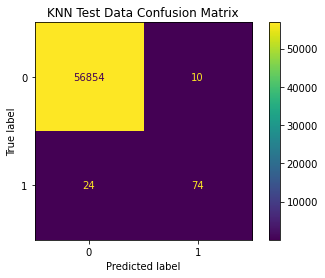

time: 315 ms (started: 2022-05-10 00:52:06 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, knn_preds, labels=knn_pipe.classes_),
    display_labels=knn_pipe.classes_
    )
disp.plot()
plt.title("KNN Test Data Confusion Matrix")
plt.show()

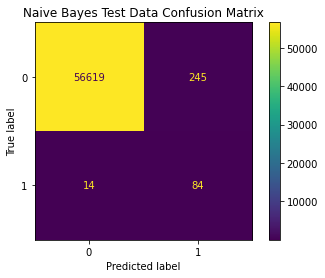

time: 320 ms (started: 2022-05-10 01:00:01 +00:00)


In [ ]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, naive_preds, labels=naive_bayes_pipe.classes_),
    display_labels=naive_bayes_pipe.classes_
    )
disp.plot()
plt.title("Naive Bayes Test Data Confusion Matrix")
plt.show()

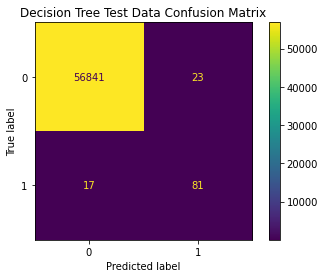

time: 302 ms (started: 2022-05-10 00:55:19 +00:00)


In [ ]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, dt_pipe_preds, labels=dt_pipe.classes_),
    display_labels=dt_pipe.classes_
    )
disp.plot()
plt.title("Decision Tree Test Data Confusion Matrix")
plt.show()

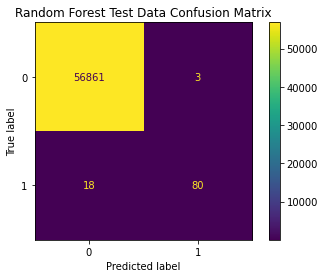

time: 193 ms (started: 2022-05-10 00:56:02 +00:00)


In [ ]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, random_forest_preds, labels=rf_pipe.classes_),
    display_labels=rf_pipe.classes_
    )
disp.plot()
plt.title("Random Forest Test Data Confusion Matrix")
plt.show()

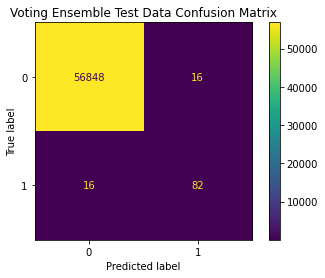

time: 305 ms (started: 2022-05-10 01:03:11 +00:00)


In [ ]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, voting_clf_preds, labels=voting_clf_pipe.classes_),
    display_labels=voting_clf_pipe.classes_
    )
disp.plot()
plt.title("Voting Ensemble Test Data Confusion Matrix")
plt.show()